# Demo: Retrieving basic entities

## Import python modules

In [1]:
import graphsense
from graphsense.api import addresses_api, blocks_api, entities_api

import matplotlib.pyplot as plt

from pprint import pprint

## Configure and create API endpoint

In [2]:
configuration = graphsense.Configuration(
    host = "http://spark-master:9001",
    api_key = 'YOUR_API_KEY'
)

CURRENCY = 'btc'

## Case study #1

Let's have a look at some properties of block 500000 in the BTC blockchain.

In [5]:
with graphsense.ApiClient(configuration) as api_client:
    api_instance = blocks_api.BlocksApi(api_client)
    try:
        # Retrieve the list of all transactions in a block
        block_txs_obj = api_instance.list_block_txs(CURRENCY, 500000)
        # pprint(block_txs_obj)
    except graphsense.ApiException as e:
        print("Exception when calling BlocksApi->list_block_txs: %s\n" % e)

Let's compute the paid fees and the ratio between fees and and total inputs for each transaction.

In [6]:
block_tx_fees = [tx.total_input.value - tx.total_output.value
                 for tx in block_txs_obj if tx.no_inputs > 0]
block_tx_inputs = [tx.total_input.value for tx in block_txs_obj if tx.no_inputs > 0]
block_tx_fee_input_ratios = [f/i for f, i in zip(block_tx_fees, block_tx_inputs)]

Let's plot the results to visually identify some patterns.

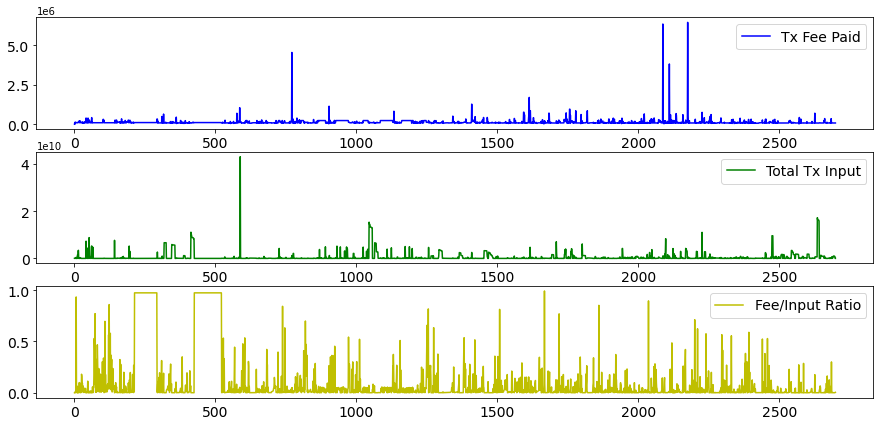

In [7]:
fs = 14
n_subplots = 3
fig, axs = plt.subplots(n_subplots, figsize=(15, 7))
axs[0].plot(block_tx_fees, 'b', label='Tx Fee Paid')

axs[1].plot(block_tx_inputs, 'g', label='Total Tx Input')

axs[2].plot(block_tx_fee_input_ratios, 'y', label='Fee/Input Ratio')

for i in range(n_subplots):
    axs[i].legend(fontsize=fs)
    axs[i].tick_params(labelsize=fs)
plt.show()

There is something weird happening around tx number 250 and around tx number 500 where the ratio is constant and close to 1. Let's check the numbers in the block. 

In [8]:
delta = 3
print('index, ratio, input, fee')
for i, el in enumerate(block_tx_fee_input_ratios):
    if el > 0.9 and ((i > 250 - delta and i < 250 + delta) or (i > 500 - delta and i < 500 + delta)):
        print(i, el, block_tx_inputs[i], block_tx_fees[i])

index, ratio, input, fee
248 0.9734254842791784 102730 100000
249 0.9734254842791784 102730 100000
250 0.9734254842791784 102730 100000
251 0.9734254842791784 102730 100000
252 0.9734254842791784 102730 100000
498 0.9734254842791784 102730 100000
499 0.9734254842791784 102730 100000
500 0.9734254842791784 102730 100000
501 0.9734254842791784 102730 100000
502 0.9734254842791784 102730 100000


Let's check how many transactions follow this pattern.

In [9]:
from statistics import mode

In [10]:
ratio_mode = mode(block_tx_fee_input_ratios)
ratio_mode

0.9734254842791784

In [11]:
n_txs_with_pattern = len([el for el in block_tx_fee_input_ratios if el == ratio_mode])
n_txs_with_pattern

177

In [12]:
ratio_txs_with_pattern = 100*n_txs_with_pattern/len(block_txs_obj)
ratio_txs_with_pattern

6.55312847093669

We have 177 transactions in block 500000 (~6.55%) that follow a specific input-fee pattern and these have likely been performed by the same actor.

## Case Study #2

Let's play with an address and its entity and see what we can discover about their relations.

In [13]:
address = '18NSAybFEhLa6AG3gxEN1hiaRJoSvvbnDb'

with graphsense.ApiClient(configuration) as api_client:
    api_instance = addresses_api.AddressesApi(api_client)
    try:
        # Retrieve the address object
        address_obj = api_instance.get_address(CURRENCY, address)
        # pprint(address_obj)
        entity_obj = api_instance.get_address_entity(CURRENCY, address)
        # pprint(entity_obj)
    except graphsense.ApiException as e:
        print("Exception when calling AddressesApi: %s\n" % e)

Let's check some simple properties of the address and of the entity and then compare their number of incoming and outgoing transactions.

In [14]:
address_obj.total_received

{'eur': 57741.75, 'usd': 67537.25, 'value': 1439242418}

In [15]:
address_obj.balance

{'eur': 0.0, 'usd': 0.0, 'value': 0}

In [16]:
entity_obj.no_addresses

12

In [17]:
from datetime import datetime

In [18]:
print('First Tx:', datetime.utcfromtimestamp(entity_obj.first_tx.timestamp).strftime('%Y-%m-%d %H:%M:%S'))

First Tx: 2016-12-15 02:37:11


In [19]:
print('Last Tx:', datetime.utcfromtimestamp(entity_obj.last_tx.timestamp).strftime('%Y-%m-%d %H:%M:%S'))

Last Tx: 2020-01-20 13:43:06


In [20]:
address_obj.no_incoming_txs, entity_obj.no_incoming_txs

(34, 34)

In [21]:
address_obj.no_outgoing_txs, entity_obj.no_outgoing_txs

(16, 16)

It looks like this address was used in all the incoming and outgoing transactions of the entity. Let's discover more about this entity.

In [22]:
with graphsense.ApiClient(configuration) as api_client:
    api_instance = entities_api.EntitiesApi(api_client)
    try:
        # Retrieve the entity object (including tags)
        entity_with_tags_obj = api_instance.get_entity(CURRENCY, entity_obj.entity, include_tags=True)
        # pprint(entity_with_tags_obj)
    except graphsense.ApiException as e:
        print("Exception when calling EntitiesApi: %s\n" % e)

In [23]:
entity_with_tags_obj.tags

{'address_tags': [], 'entity_tags': []}

Unfortunately, we have no tags for this entity. Let's check its incoming neighbors!

In [27]:
with graphsense.ApiClient(configuration) as api_client:
    api_instance = entities_api.EntitiesApi(api_client)
    try:
        # Retrieve entity neighbors
        entity_neighbors_obj = api_instance.list_entity_neighbors('btc', entity_with_tags_obj.entity, direction='in')
    except graphsense.ApiException as e:
        print("Exception when calling EntitiesApi: %s\n" % e)

First, it's better to check how many incoming neighbors we are dealing with

In [28]:
len(entity_neighbors_obj.neighbors)

32

Not too many, we can work with them. Let's see if we are lucky with the labels of the incoming neighbors!

In [30]:
entity_neighbors_obj.neighbors

[{'balance': {'eur': 0.0, 'usd': 0.0, 'value': 0},
  'estimated_value': {'eur': 4450.04, 'usd': 4636.92, 'value': 597941373},
  'has_labels': False,
  'id': '167096340',
  'no_txs': 2,
  'node_type': 'entity',
  'received': {'eur': 4857.55, 'usd': 5341.0, 'value': 846080671}},
 {'balance': {'eur': 0.0, 'usd': 0.0, 'value': 0},
  'estimated_value': {'eur': 723.89, 'usd': 782.76, 'value': 74959320},
  'has_labels': False,
  'id': '228927578',
  'no_txs': 1,
  'node_type': 'entity',
  'received': {'eur': 142903.28, 'usd': 157322.98, 'value': 9797390000}},
 {'balance': {'eur': 0.0, 'usd': 0.0, 'value': 0},
  'estimated_value': {'eur': 0.45, 'usd': 0.49, 'value': 50698},
  'has_labels': False,
  'id': '238609525',
  'no_txs': 1,
  'node_type': 'entity',
  'received': {'eur': 0.47, 'usd': 0.51, 'value': 52690}},
 {'balance': {'eur': 0.0, 'usd': 0.0, 'value': 0},
  'estimated_value': {'eur': 19.21, 'usd': 20.87, 'value': 2005864},
  'has_labels': False,
  'id': '239190095',
  'no_txs': 1,
  '

In [29]:
[el.labels for el in entity_neighbors_obj.neighbors if el.labels]

ApiAttributeError: Neighbor has no attribute 'labels' at ['['received_data', 'neighbors', 0]']['labels']

Bingo! We found some known entities sending money to our entity: some exchanges (Poloniex, Shapeshift) and a coinjoin provider (Wasabi).